# Nesterov Accelerated Stochastic Gradient Descent

We implement accelerated SGD and compare it with mini-batch SGD in terms of convergence speed. This only requires a simple modification of the Python code for SGD, which makes machine learning process faster.

##  Binary Logistic Regression

#### Loss Function

Given a data sample $\mathbf{x}_i=(1, x_1,\dots,x_p)$ (saved as row vector) with $p$ features, the prediction is

$$
\hat{y}_i = P(Y=1|X= \mathbf{x}_i) =  \frac{1}{1+ e^{-\mathbf{x}_i^\top \boldsymbol \theta  }}
$$ 

The **cross-entropy/log loss** for the $i$-th sample is given by

\begin{align*}
l_i(\boldsymbol \theta ) = - y_i \log \hat{y}_i - (1-y_i) \log (1 - \hat{y}_i)
\end{align*}

Want to solve

$$
\min_{\boldsymbol \theta\in\mathbb{R}^{p+1}} \; L(\boldsymbol \theta ) := \frac{1}{n}\sum_{i=1}^n l_i(\boldsymbol \theta )
$$

#### Gradient in Matrix Form
Denote the sigmoid function by $\sigma(z) := \frac{1}{1+e^{-z}}$, we have

\begin{align*}
\nabla l_i(\boldsymbol \theta ) = \mathbf{x}_i(\hat{y}_i - y_i) 
\end{align*}

and

$$
\nabla L(\boldsymbol \theta)  = \frac{1}{n} \mathbf{X}^\top (\mathbf{\hat{y}}- \mathbf{y})
= \frac{1}{n} \mathbf{X}^\top \left(\sigma(\mathbf{X}\boldsymbol\theta) - \mathbf{y}\right)
$$

where the $i$-th row of $\mathbf{X}\in\mathbb{R}^{n\times (p+1)}$ is $\mathbf{x}_i^\top$.


## Mini-Batch SGD

**(Standard) gradient descent**: with the learning rate $\eta>0$,

$$
\boldsymbol \theta \leftarrow \boldsymbol \theta - \eta \left(\frac{1}{n} \sum_{i=1}^n \nabla l_i(\boldsymbol \theta )\right)
$$


**Stochastic gradient descent**: Randomly group the training samples into batches of size $b \ll n$. In each iteration, choose one batch $\mathcal{I}$ **without replacement** and update $\boldsymbol \theta $ using the averaged gradients over the samples in the batch:

$$
\boldsymbol \theta \leftarrow \boldsymbol \theta - \eta \left(\frac{1}{b} \sum_{i\in \mathcal{I}} \nabla l_i(\boldsymbol \theta )\right)
$$

where 
$$
\sum_{i\in \mathcal{I}} \nabla l_i(\boldsymbol \theta ) = \mathbf{X}_{\mathcal{I}}^\top \left(\sigma(\mathbf{X}_{\mathcal{I}} \boldsymbol\theta) - \mathbf{y}_{\mathcal{I}}\right)
$$
is the **mini-batch gradient**. $\mathbf{X}_{\mathcal{I}}$ is the submatrix of $\mathbf{X}$ with row indices in $\mathcal{I}$.


* when one pass (known as **epoch**) of the entire training dataset has been completed, start the next epoch by reshuffling the data. 

* train for a number of epochs 

* ideally, take diminishing $\eta \downarrow 0$ as SGD proceeds

* $\frac{1}{b} \sum_{i\in \mathcal{I}} \nabla l_i(\boldsymbol \theta )$ is unbiased estimate of $\frac{1}{n} \sum_{i=1}^n \nabla l_i(\boldsymbol \theta )$

* \# iterations in one epoch $= \frac{n}{b}$, roughly

* implementation of SGD consists of two ``for`` loops

## Nesterov Accelerated Gradient Method

The Nesterov Accelerated Gradient method, named after the mathematician [Yurii Nesterov](https://en.wikipedia.org/wiki/Yurii_Nesterov), consists of a gradient descent step, followed by something that looks like prolongation, approximating a future position of our parameters $\boldsymbol \theta$.  We call it a “momentum step” here. 

* The gradient descent step is performed at the approximated future position $\boldsymbol\gamma$ with learning rate $\eta >0$:

$$
\boldsymbol \theta \leftarrow \boldsymbol\gamma - \eta \nabla L(\boldsymbol\gamma)
$$

* The momentum step approximates $\boldsymbol\gamma$ with the momentum $\mu\in(0,1)$ (requires storage of the previous iterate):

$$
\boldsymbol\gamma \leftarrow \boldsymbol \theta+ \mu \, (\boldsymbol \theta - \boldsymbol \theta_{\mbox{prev}})
$$

**For accelerated SGD, simply replace $\nabla L(\boldsymbol\gamma)$ with mini-batch gradient in the gradient descent step.**

Check out [this plog](https://distill.pub/2017/momentum/) for a comparison between gradient descent with and without momentum .

## MNIST Data Set

We will compare the performances of SGD and accelerated SGD on MNIST data. The MNIST database of grayscale handwritten digits, available from this page http://yann.lecun.com/exdb/mnist/, has a training set of 60,000 examples, and a test set of 10,000 examples. 


**We only do binary classification to recognize digits of 0 and 9.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Get the Data

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

## Data Preparation

There are in total 70,000 samples, each with 784 features corresponding to the grayscale values of 28x28 image pixels.

In [5]:
data = np.array(mnist['data'])
print(data.shape)
labels = np.array(mnist['target']).astype(int)
print(labels.shape)
print(labels[:10])

(70000, 784)
(70000,)
[5 0 4 1 9 2 1 3 1 4]


Split into training set and test set

In [6]:
data_train, data_test, labels_train, labels_test = data[:60000], data[60000:], labels[:60000], labels[60000:]
print(labels_train.shape)

(60000,)


We build a new data set by picking out the samples for digits 0 and 9. **label = 0 for digit 0, and label = 1 for digit 9**

In [7]:
def img_select(X,y):
    index  = (y==0) | (y==9)
    return X[index], y[index]//9

In [8]:
X_train, y_train  = img_select(data_train, labels_train)
print('There are', len(y_train), 'training samples')
X_test, y_test  = img_select(data_test, labels_test)
print('There are', len(y_test), 'test samples')
print(y_train[:10])

There are 11872 training samples
There are 1989 test samples
[0 1 1 0 1 1 0 0 1 1]


**Normalize inputs from 0-255 to 0-1**

In [9]:
X_train = X_train / 255
X_test = X_test / 255

Plot four image samples from data set

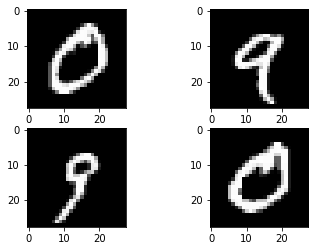

In [10]:
plt.subplot(2,2,1)
plt.imshow(X_train[0].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(2,2,2)
plt.imshow(X_train[1].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(2,2,3)
plt.imshow(X_train[2].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(2,2,4)
plt.imshow(X_train[3].reshape(28,28), cmap=plt.get_cmap('gray'))

## Train Model

**Build a class of LogisticClassifier object**

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
class LogisticClassifier(object):
    def __init__(self, lr=0.1, epochs=100, batch_size=100, momentum = 0.9, normalize = False):
        # sgd parameters
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.momentum = momentum
        self.normalize = normalize
        
        self.loss_history = []
        self.accuracy_history = []
    
        

    def _assemble_x(self, X):
        # nomarlize the data and concatenate ones 
        if self.normalize:
            means = X.mean(axis=0)
            std = np.std(X, axis=0)
            X = (X - means)/std        
        # add intercept column to the design matrix
        X = np.hstack([ np.ones((X.shape[0], 1)), X])
        return X
        
    def fit(self, X, y):
        n, p = X.shape # n = # samples, p = # features
        X = self._assemble_x(X)       
    
        # initialize parameters
        # self.theta = np.random.randn(p + 1)
        self.theta = np.zeros(p + 1)
        # parameters for Nesterov
        gamma = self.theta
        theta_old = self.theta
            
        for epoch in range(self.epochs):
            
            # shuffle the samples
            shuffle = np.random.permutation(n)
            X = X[shuffle, :]
            y = y[shuffle]
        
            # if batch_size does not evenly divide n, we'll one more
            # batch of size less than batch_size at the end.
            r = (1 if n % self.batch_size else 0)
            
            for i in range(n // self.batch_size + r):
                batch_slice = slice(self.batch_size * i, self.batch_size * (i + 1) )
                X_batch = X[batch_slice, :]
                y_batch = y[batch_slice]
        
                y_hat = sigmoid(X_batch @ gamma)
                # update parameters
                gradient = X_batch.T @ (y_hat - y_batch)/self.batch_size

                self.theta = gamma - self.lr * gradient
                gamma = self.theta + self.momentum*(self.theta - theta_old)
                theta_old = self.theta
                
            y_hat = sigmoid(X @ self.theta)
            loss = np.mean(-y * np.log(y_hat) - (1-y) * np.log(1-y_hat))
            self.loss_history.append(loss)
            y_preds = (y_hat > 0.5).astype(int)
            accuracy = self.accuracy(y_preds,y)
            self.accuracy_history.append(accuracy)
            if (epoch + 1)%10 == 0:
                print('Epoch', epoch, ': training loss=', "{:.5f}".format(loss), ', training accuracy=', accuracy, '%' )

        
    def predict(self, X):
        X = self._assemble_x(X)
        return (X @ self.theta > 0).astype(int)
    
    def accuracy(self, y_preds, y):
        return np.mean(y_preds == y)*100

**We are not going to further normalize the data by substracting mean and division by std, because the data is sparse!**

## Compare SGD with and without Nesterov momentum

**Train the model using accelerated SGD with momentum $\mu = 0.9$**

In [13]:
model1 = LogisticClassifier(lr = .02, batch_size = 100, epochs = 500, momentum=0.9)
%time model1.fit(X_train, y_train)

Epoch 9 : training loss= 0.01778 , training accuracy= 99.4777628032345 %
Epoch 19 : training loss= 0.01496 , training accuracy= 99.55357142857143 %
Epoch 29 : training loss= 0.01328 , training accuracy= 99.62095687331536 %
Epoch 39 : training loss= 0.01223 , training accuracy= 99.64622641509435 %
Epoch 49 : training loss= 0.01185 , training accuracy= 99.65464959568733 %
Epoch 59 : training loss= 0.01089 , training accuracy= 99.6967654986523 %
Epoch 69 : training loss= 0.01051 , training accuracy= 99.71361185983828 %
Epoch 79 : training loss= 0.01000 , training accuracy= 99.73045822102425 %
Epoch 89 : training loss= 0.00961 , training accuracy= 99.74730458221023 %
Epoch 99 : training loss= 0.00929 , training accuracy= 99.76415094339622 %
Epoch 109 : training loss= 0.00898 , training accuracy= 99.76415094339622 %
Epoch 119 : training loss= 0.00874 , training accuracy= 99.77257412398922 %
Epoch 129 : training loss= 0.00851 , training accuracy= 99.77257412398922 %
Epoch 139 : training loss

**Train the model using vanilla SGD with momentum $\mu = 0$**

In [43]:
model2 = LogisticClassifier(lr = .02, batch_size = 100, epochs = 500, momentum=0)
%time model2.fit(X_train, y_train)

Epoch 9 : training loss= 0.05130 , training accuracy= 98.843537414966 %
Epoch 19 : training loss= 0.04092 , training accuracy= 98.9625850340136 %
Epoch 29 : training loss= 0.03663 , training accuracy= 99.02210884353741 %
Epoch 39 : training loss= 0.03412 , training accuracy= 99.0561224489796 %
Epoch 49 : training loss= 0.03237 , training accuracy= 99.06462585034014 %
Epoch 59 : training loss= 0.03106 , training accuracy= 99.07312925170068 %
Epoch 69 : training loss= 0.03002 , training accuracy= 99.08163265306122 %
Epoch 79 : training loss= 0.02915 , training accuracy= 99.08163265306122 %
Epoch 89 : training loss= 0.02843 , training accuracy= 99.10714285714286 %
Epoch 99 : training loss= 0.02779 , training accuracy= 99.13265306122449 %
Epoch 109 : training loss= 0.02723 , training accuracy= 99.14965986394559 %
Epoch 119 : training loss= 0.02674 , training accuracy= 99.15816326530611 %
Epoch 129 : training loss= 0.02629 , training accuracy= 99.16666666666667 %
Epoch 139 : training loss= 

**Create plots for the training losses and accuracies**

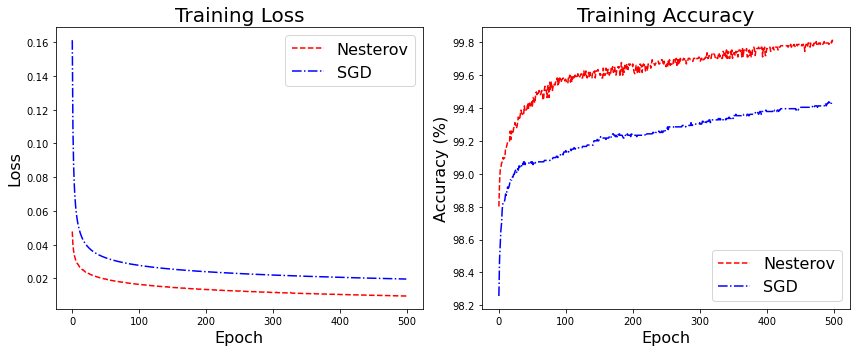

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 5))

ax1.plot(model1.loss_history, 'r--', label = 'Nesterov')
ax1.plot(model2.loss_history, 'b-.', label = 'SGD')
ax1.set_xlabel('Epoch',fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_title('Training Loss', fontsize=20);

ax1.legend(loc=0, fontsize = 16)

ax2.plot(model1.accuracy_history, 'r--', label = 'Nesterov')
ax2.plot(model2.accuracy_history, 'b-.', label = 'SGD')
ax2.set_xlabel('Epoch', fontsize=16)
ax2.set_ylabel('Accuracy (%)', fontsize=16)
ax2.set_title('Training Accuracy', fontsize=20)

ax2.legend(loc=0, fontsize = 16)

fig.tight_layout()

Accelerated SGD noticeably converges faster than SGD

**Compare test accuracies**

In [45]:
yte2_preds = model2.predict(X_test)
print('Test accuracy using vanilla SGD: ', model1.accuracy(yte2_preds,y_test), '%')

yte1_preds = model1.predict(X_test)
print('Test accuracy using Nesterov momentum: ', model2.accuracy(yte1_preds,y_test), '%')

Test accuracy using vanilla SGD:  99.12371134020619 %
Test accuracy using Nesterov momentum:  99.17525773195877 %


**Check out the misrecognized test images** 

In [46]:
y_wrong = y_test[yte1_preds != y_test]
X_wrong = X_test[yte1_preds != y_test]
print('There are', X_wrong.shape[0], 'misclassified test images')

There are 16 misclassified test images


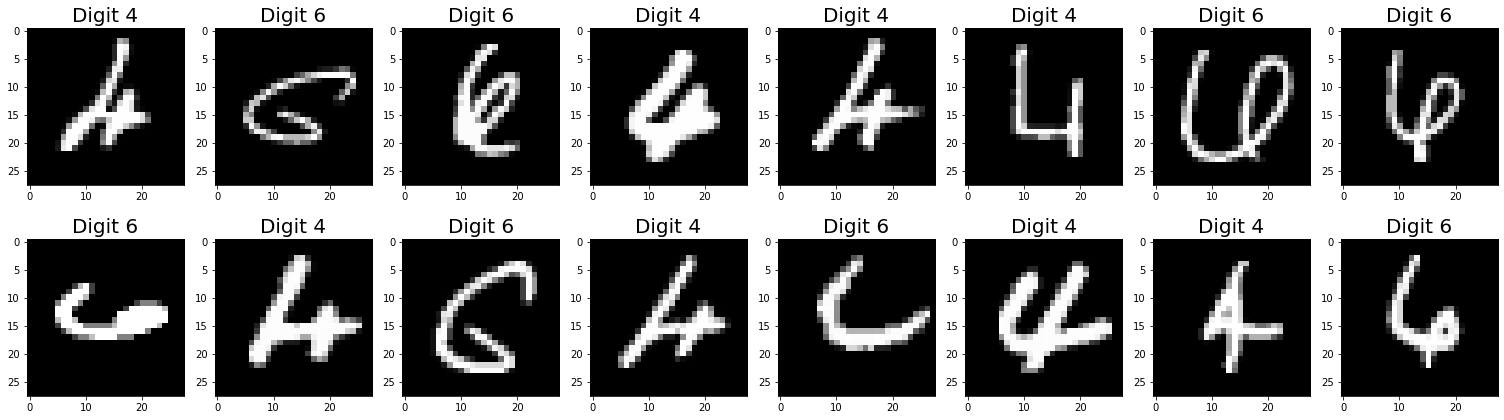

In [48]:
fig, axes = plt.subplots(2,8,figsize=(21,6))
for i, ax in enumerate(axes.flat):
    if i < len(y_wrong):
        ax.imshow(X_wrong[i].reshape(28,28), cmap=plt.get_cmap('gray'))
        ax.set_title('Digit {}'.format(2*y_wrong[i]+4), fontsize=20)  
fig.tight_layout()

In [49]:
y_wrong = y_test[yte2_preds != y_test]
X_wrong = X_test[yte2_preds != y_test]
print('There are', X_wrong.shape[0], 'misclassified test images')

There are 17 misclassified test images


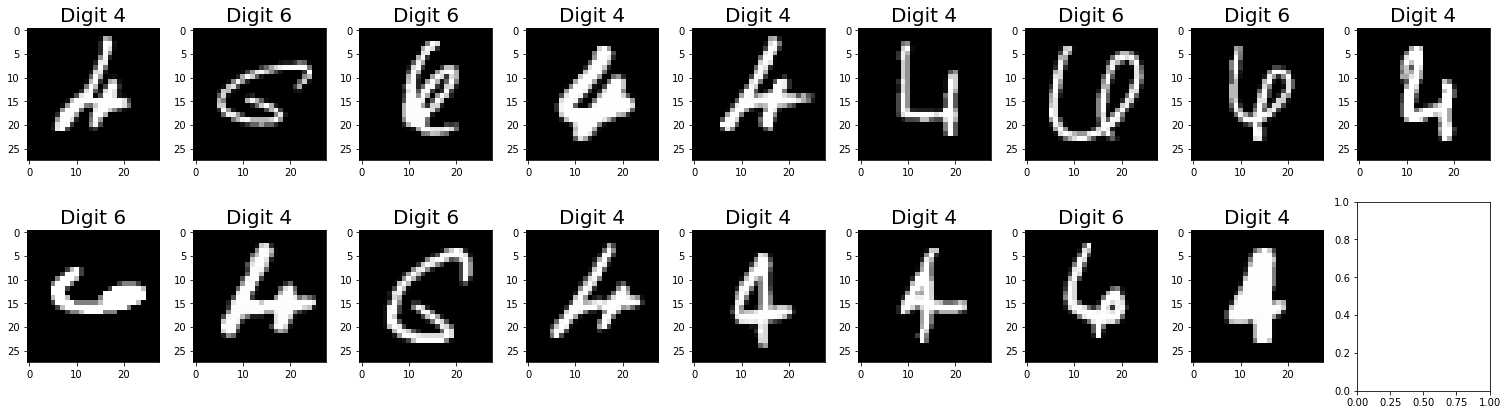

In [50]:
fig, axes = plt.subplots(2,9,figsize=(21,6))
for i, ax in enumerate(axes.flat):
    if i < len(y_wrong):
        ax.imshow(X_wrong[i].reshape(28,28), cmap=plt.get_cmap('gray'))
        ax.set_title('Digit {}'.format(2*y_wrong[i]+4), fontsize=20)  
fig.tight_layout()

## Exercise

Train a binary logistic regression classifier to distinguish between images of digit 4 and digit 6 in MNIST, using the other momentum method in comparison to SGD.

In [34]:
def img_select(X,y):
    index  = (y==4) | (y==6)
    return X[index], (y[index]-4)//2

In [38]:
class LogisticClassifier(object):
    def __init__(self, lr=0.1, epochs=100, batch_size=100, momentum = 0.9, normalize = False):
        # sgd parameters
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.momentum = momentum
        self.normalize = normalize
        
        self.loss_history = []
        self.accuracy_history = []
    
        

    def _assemble_x(self, X):
        # nomarlize the data and concatenate ones 
        if self.normalize:
            means = X.mean(axis=0)
            std = np.std(X, axis=0)
            X = (X - means)/std        
        # add intercept column to the design matrix
        X = np.hstack([ np.ones((X.shape[0], 1)), X])
        return X
        
    def fit(self, X, y):
        n, p = X.shape # n = # samples, p = # features
        X = self._assemble_x(X)       
    
        # initialize parameters
        # self.theta = np.random.randn(p + 1)
        self.theta = np.zeros(p + 1)
        # parameters for Nesterov
        gamma = self.theta
        theta_old = self.theta
            
        for epoch in range(self.epochs):
            
            # shuffle the samples
            shuffle = np.random.permutation(n)
            X = X[shuffle, :]
            y = y[shuffle]
        
            # if batch_size does not evenly divide n, we'll one more
            # batch of size less than batch_size at the end.
            r = (1 if n % self.batch_size else 0)
            
            for i in range(n // self.batch_size + r):
                batch_slice = slice(self.batch_size * i, self.batch_size * (i + 1) )
                X_batch = X[batch_slice, :]
                y_batch = y[batch_slice]
        
                y_hat = sigmoid(X_batch @ self.theta)
                # update parameters
                gradient = X_batch.T @ (y_hat - y_batch)/self.batch_size

                self.theta = gamma - self.lr * gradient
                gamma = self.theta + self.momentum*(self.theta - theta_old)
                theta_old = self.theta
                
            y_hat = sigmoid(X @ self.theta)
            loss = np.mean(-y * np.log(y_hat) - (1-y) * np.log(1-y_hat))
            self.loss_history.append(loss)
            y_preds = (y_hat > 0.5).astype(int)
            accuracy = self.accuracy(y_preds,y)
            self.accuracy_history.append(accuracy)
            if (epoch + 1)%10 == 0:
                print('Epoch', epoch, ': training loss=', "{:.5f}".format(loss), ', training accuracy=', accuracy, '%' )

        
    def predict(self, X):
        X = self._assemble_x(X)
        return (X @ self.theta > 0).astype(int)
    
    def accuracy(self, y_preds, y):
        return np.mean(y_preds == y)*100

In [39]:
X_train, y_train  = img_select(data_train, labels_train)
print('There are', len(y_train), 'training samples')
X_test, y_test  = img_select(data_test, labels_test)
print('There are', len(y_test), 'test samples')
print(y_train[:10])

There are 11760 training samples
There are 1940 test samples
[0 0 1 1 0 0 1 1 1 0]


In [40]:
X_train = X_train / 255
X_test = X_test / 255

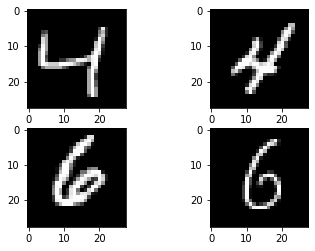

In [41]:
plt.subplot(2,2,1)
plt.imshow(X_train[0].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(2,2,2)
plt.imshow(X_train[1].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(2,2,3)
plt.imshow(X_train[2].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(2,2,4)
plt.imshow(X_train[3].reshape(28,28), cmap=plt.get_cmap('gray'))